In [32]:
# !pip install qiskit
# !pip install scipy

# VQLS with Qiskit
**Course**: Applied Quantum Algorithms

**Date**: April 20, 2022

In this notebook, we will solve a linear system of the form
$$
A|x\rangle = |b\rangle
$$
by implementing the VQLS algorithm in Qiskit.

We will first build some of the functions ourselves and verify them, but then use the compact libraries of Qiskit to build the final version of the cost function for optimization.

In [1]:
import numpy as np
import scipy
from qiskit import Aer
from qiskit.circuit.library.n_local import TwoLocal
from qiskit.opflow import (Z, I, H, CircuitStateFn, StateFn)
from qiskit.quantum_info import Statevector

## Ansatz

First off, we know that all hybrid variational algorithms use a parametrized quantum circuit $U(\theta)$ to represent the tentative solution as

$$
|\psi(\theta)\rangle = U(\theta) |0\rangle^{\otimes n},
$$

where $N$ is the dimension of our linear system and $n=\log_2 N$.

For this exercise, we want to build the following ansatz on 3 qubits

![ansatz](ansatz.png)

Notice that the CZ-gates are arranged with a *full-entanglement* logic, so controls and targets are respectively:
1. 0 -> 1
2. 0 -> 2
3. 1 -> 2

In [3]:
from qiskit import QuantumCircuit

def build_ansatz(params):
    """
    Returns the ansatz circuit for representing |\psi(\theta)>
    
    Arguments:
        params: np.ndarray containing the parameters of the rotation gates
    """
    qc = QuantumCircuit(3)
    
    # ===============
    # YOUR CODE BELOW
    # ===============
    
    return qc

Let's check our implementation using some random parameters as argument to our function

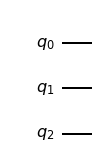

In [4]:
rng = np.random.default_rng(1)

theta_0 = rng.uniform(-2 * np.pi, 2 * np.pi, size=6)

ansatz = build_ansatz(theta_0)

ansatz.draw(output='mpl')

Instead of creating parametrized circuits yourself, Qiskit offers a set of ansatz templates that you can directly use. For instance, we can use the `TwoLocal` class to produce the same ansatz that we just created

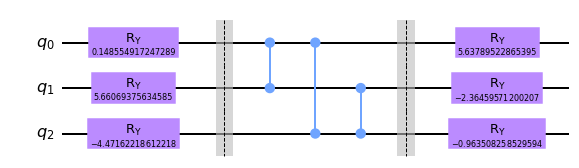

In [5]:
ansatz = TwoLocal(3, 'ry', 'cz', 'full', reps=1, insert_barriers=True)
qc = ansatz.assign_parameters(theta_0).decompose()
qc.draw(output='mpl')

## Expectation value

Let's assume that our problem is the following:

Find $|x\rangle$, such that $A|x\rangle=|b\rangle$, where

$$
A = 0.55 I + 0.225 Z_1 + 0.225 Z_2
$$

and

$$
|b\rangle = B |0\rangle^{\otimes 3} = H^{\otimes 3} |0\rangle^{\otimes 3}.
$$

We know that a possible cost function used in VQLS is

$$
C(\theta) = \langle\psi(\theta)| A^\dagger (I - |b\rangle\langle b|) A |\psi(\theta)\rangle,
$$

which we can also write as

$$
C(\theta) = \langle\psi(\theta)| A^\dagger A |\psi(\theta)\rangle - \langle\psi(\theta)| A^\dagger B |0\rangle\langle 0 | B^\dagger A |\psi(\theta)\rangle.
$$

In [6]:
backend = Aer.get_backend('statevector_simulator')

In [7]:
A = 0.55 * (I ^ I ^ I) \
    + 0.225 * (I ^ Z ^ I) \
        + 0.225 * (I ^ I ^ Z)

B = (H ^ H ^ H).to_pauli_op()

In [10]:
A_squared = (~A) @ A

In [12]:
zero_proj = 0.5 * (I + Z)
zero_proj_3 = zero_proj ^ zero_proj ^ zero_proj

In [13]:
print(zero_proj_3.to_matrix())

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]]


In [14]:
A_b_proj = (~A) @ (~B) @ zero_proj_3 @ B @ A

In [15]:
print(A_b_proj)

ComposedOp([
  0.55 * III
  + 0.225 * IZI
  + 0.225 * IIZ,
  SummedOp([
    0.3535533905932737 * XXX,
    0.3535533905932737 * XXZ,
    0.3535533905932737 * XZX,
    0.3535533905932737 * XZZ,
    0.3535533905932737 * ZXX,
    0.3535533905932737 * ZXZ,
    0.3535533905932737 * ZZX,
    0.3535533905932737 * ZZZ
  ]),
  0.125 * III
  + 0.125 * IIZ
  + 0.125 * IZI
  + 0.125 * IZZ
  + 0.125 * ZII
  + 0.125 * ZIZ
  + 0.125 * ZZI
  + 0.125 * ZZZ,
  SummedOp([
    0.3535533905932737 * XXX,
    0.3535533905932737 * XXZ,
    0.3535533905932737 * XZX,
    0.3535533905932737 * XZZ,
    0.3535533905932737 * ZXX,
    0.3535533905932737 * ZXZ,
    0.3535533905932737 * ZZX,
    0.3535533905932737 * ZZZ
  ]),
  0.55 * III
  + 0.225 * IZI
  + 0.225 * IIZ
])


In [16]:
ansatz = TwoLocal(3, 'ry', 'cz', 'full', reps=1, insert_barriers=True)
# fig = ansatz.decompose().draw(output='mpl')
# fig.savefig('ansatz.png', bbox_inches='tight')
print(ansatz.assign_parameters(theta_0).decompose().qasm())

OPENQASM 2.0;
include "qelib1.inc";
qreg q[3];
ry(0.148554917247289) q[0];
ry(5.66069375634585) q[1];
ry(-4.47162218612218) q[2];
barrier q[0],q[1],q[2];
cz q[0],q[1];
cz q[0],q[2];
cz q[1],q[2];
barrier q[0],q[1],q[2];
ry(5.63789522865395) q[0];
ry(-2.36459571200207) q[1];
ry(-0.963508258529594) q[2];



In [25]:
theta_0 = np.random.uniform(-2 * np.pi, 2 * np.pi, size=ansatz.num_parameters)
# print(theta_0)
psi = CircuitStateFn(ansatz.assign_parameters(theta_0))
# print(psi)

In [26]:
ev1 = StateFn(A_squared).adjoint().eval(psi)
ev2 = StateFn(A_b_proj).adjoint().eval(psi)
print(ev1.real)
print(ev2.real)
# expectation = AerPauliExpectation().convert(measurable)
# sampler = CircuitSampler(backend).convert(expectation)  
# print('Snapshot:', sampler.eval().real) 

0.1781710724914834
0.004325923358459212


In [27]:
def cost(params):
    """
    Returns the global un-normalized cost function for VQLS:
    C_G = <\psi| (~A (1-|b><b|) A) |\psi>
    """
    psi = CircuitStateFn(ansatz.assign_parameters(params))
    
    ev1 = StateFn(A_squared).adjoint().eval(psi)
    ev2 = StateFn(A_b_proj).adjoint().eval(psi)

    return ev1.real - ev2.real

In [34]:
out = scipy.optimize.minimize(cost, x0=theta_0, method="COBYLA", options={'maxiter':500})
print(out)

     fun: 2.758712008832376e-10
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 115
  status: 1
 success: True
       x: array([ 0.30107569, -0.43300585,  6.28326857, -3.80030656,  3.17334075,
        1.57067111])


In [36]:
theta_opt = out.x
zero_state = Statevector.from_label('000')
psi_opt = zero_state.evolve(ansatz.assign_parameters(theta_opt))
psi_opt_vector = psi_opt.data
print(psi_opt_vector)

[0.06817589+0.j 0.12394976+0.j 0.12392745+0.j 0.68165755+0.j
 0.06816468+0.j 0.12392098+0.j 0.12393844+0.j 0.681623  +0.j]


In [37]:
A.to_matrix()
# B.to_matrix()

array([[1.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
        0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.55+0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
        0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.55+0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
        0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.  +0.j, 0.1 +0.j, 0.  +0.j, 0.  +0.j,
        0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 1.  +0.j, 0.  +0.j,
        0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.55+0.j,
        0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
        0.55+0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
        0.  +0.j, 0.1 +0.j]])

In [38]:
np.linalg.norm((A.to_matrix().real @ psi_opt_vector.real) - (1/np.sqrt(8) * np.ones(8)))

0.8071989355257846

In [39]:
zero_state = Statevector.from_label('000')
b_ket = B.to_matrix() @ zero_state.data
print(b_ket)
print(1/np.sqrt(8) * np.ones(8))

[0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j
 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j]
[0.35355339 0.35355339 0.35355339 0.35355339 0.35355339 0.35355339
 0.35355339 0.35355339]


In [40]:
x_true = np.linalg.solve(A.to_matrix(), (1/np.sqrt(8) * np.ones(8)))
print(x_true)
print(np.linalg.norm(x_true))

[0.35355339+0.j 0.64282435+0.j 0.64282435+0.j 3.53553391+0.j
 0.35355339+0.j 0.64282435+0.j 0.64282435+0.j 3.53553391+0.j]
5.186799838241633


In [41]:
x_true[0] / psi_opt_vector[0]

(5.185900935054287+0j)

In [42]:
5.1822 * psi_opt_vector

array([0.35330108+0.j, 0.64233242+0.j, 0.64221681+0.j, 3.53248574+0.j,
       0.353243  +0.j, 0.64218332+0.j, 0.64227377+0.j, 3.53230671+0.j])